In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')

train_ds['load'] = train_ds['physics'] + \
                    train_ds['chemistry'] + \
                    train_ds['biology'] + \
                    train_ds['english'] + \
                    train_ds['geography'] + \
                    train_ds['history']

test_ds['load'] = test_ds['physics'] + \
                    test_ds['chemistry'] + \
                    test_ds['biology'] + \
                    test_ds['english'] + \
                    test_ds['geography'] + \
                    test_ds['history']


train_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,10000.0,4999.5000,2886.895680,0.0,2499.75,4999.5,7499.25,9999.0
age,10000.0,45.8780,8.043929,23.0,40.00,46.0,51.00,68.0
years_of_experience,10000.0,1.9868,1.772213,0.0,0.00,2.0,3.00,10.0
lesson_price,10000.0,1699.1050,524.886654,200.0,1300.00,1500.0,2150.00,3950.0
qualification,10000.0,1.7195,0.792264,1.0,1.00,2.0,2.00,4.0
physics,10000.0,0.3750,0.484147,0.0,0.00,0.0,1.00,1.0
chemistry,10000.0,0.1329,0.339484,0.0,0.00,0.0,0.00,1.0
biology,10000.0,0.1096,0.312406,0.0,0.00,0.0,0.00,1.0
english,10000.0,0.0537,0.225436,0.0,0.00,0.0,0.00,1.0
geography,10000.0,0.0321,0.176274,0.0,0.00,0.0,0.00,1.0


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'years_of_experience'}>,
        <AxesSubplot:title={'center':'lesson_price'}>],
       [<AxesSubplot:title={'center':'qualification'}>,
        <AxesSubplot:title={'center':'physics'}>,
        <AxesSubplot:title={'center':'chemistry'}>,
        <AxesSubplot:title={'center':'biology'}>],
       [<AxesSubplot:title={'center':'english'}>,
        <AxesSubplot:title={'center':'geography'}>,
        <AxesSubplot:title={'center':'history'}>,
        <AxesSubplot:title={'center':'mean_exam_points'}>],
       [<AxesSubplot:title={'center':'load'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

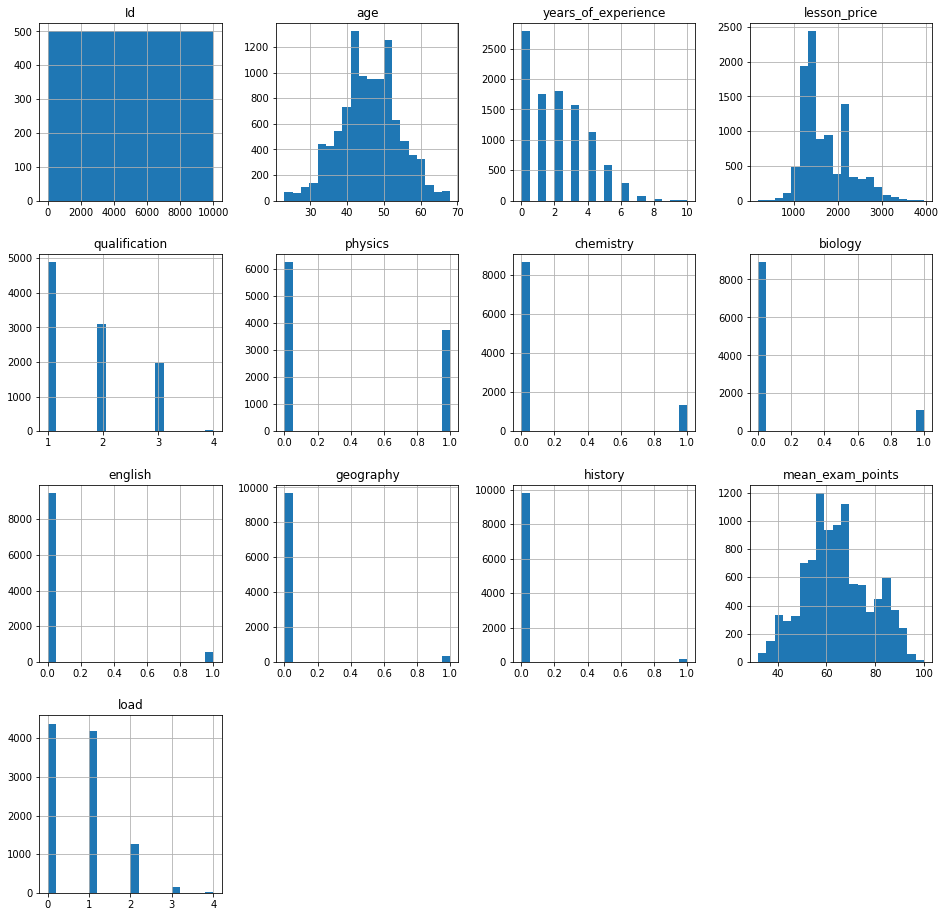

In [2]:
train_ds.hist(figsize=(16,16), bins=20)

array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'years_of_experience'}>],
       [<AxesSubplot:title={'center':'lesson_price'}>,
        <AxesSubplot:title={'center':'qualification'}>,
        <AxesSubplot:title={'center':'physics'}>],
       [<AxesSubplot:title={'center':'chemistry'}>,
        <AxesSubplot:title={'center':'biology'}>,
        <AxesSubplot:title={'center':'english'}>],
       [<AxesSubplot:title={'center':'geography'}>,
        <AxesSubplot:title={'center':'history'}>,
        <AxesSubplot:title={'center':'load'}>]], dtype=object)

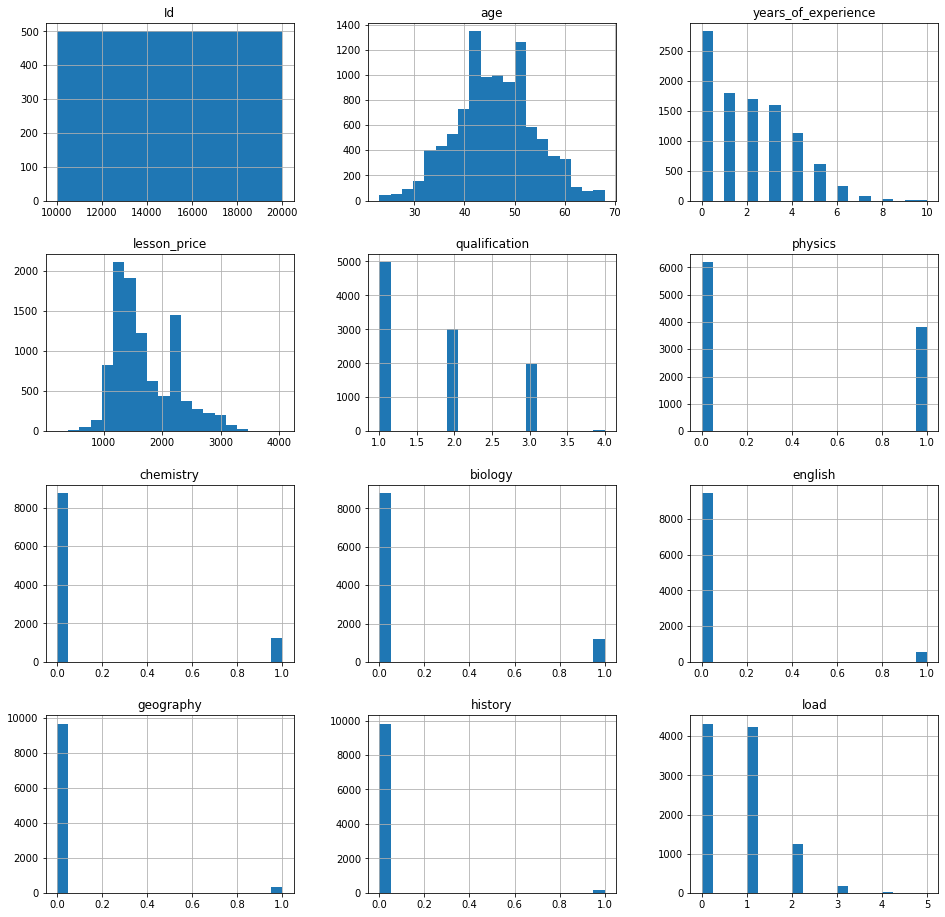

In [3]:
test_ds.hist(figsize=(16,16), bins=20)

In [4]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0 # энтропия Шеннона
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_info, info_f):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_info - p * info_f(left_labels) - (1 - p) * info_f(right_labels)

# Реализуем класс узла

def dispersion(labels):
    return np.std(labels) ** 2

def calc_mse(y, y_pred):
    return np.mean((y - y_pred)**2)


# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction

class DT_regressor():
    def __init__(self, X_data, y_data, max_depth=5, min_leaf=5, featureSelection=False):
        
        self.X_data = X_data
        self.y_data = y_data
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.info_f = dispersion
        self.featureSelection = featureSelection
            
        self.__tree_depth = 0
            
        self.__tree = self.__build_tree(self.X_data, self.y_data)
   
    def __get_subsample(self):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(self.X_data.shape[1])]
        len_subsample = int(np.sqrt(self.X_data.shape[1]))
        subsample = []
        np.random.shuffle(sample_indexes)
        subsample = sample_indexes[:len_subsample]
        return subsample
    
    def __split(self, data, labels, index, t): # Разбиение датасета в узле
    
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)
        
        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels
    
    
    def __find_best_split(self, data, labels): # Нахождение наилучшего разбиения
    
        #  обозначим минимальное количество объектов в узле
        #min_leaf = 5
        
        current_info = self.info_f(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
        
        if self.featureSelection:
            subsamples = self.__get_subsample()
        else:
            subsamples = range(n_features)
    
        for index in subsamples:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
        
            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
            
                current_quality = quality(true_labels, false_labels, current_info, self.info_f)
            
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    

    def __build_tree(self, data, labels): # Построение дерева с помощью рекурсивной функции

        quality, t, index = self.__find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.__split(data, labels, index, t)

        self.__tree_depth += 1
        
        # Рекурсивно строим два поддерева
        if self.__tree_depth <= self.max_depth:
            true_branch = self.__build_tree(true_data, true_labels)
            false_branch = self.__build_tree(false_data, false_labels)
        else:
            return Leaf(data, labels)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    def __classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.__classify_object(obj, node.true_branch)
        else:
            return self.__classify_object(obj, node.false_branch)
        
    def predict(self, data):
        classes = []
        for obj in data:
            prediction = self.__classify_object(obj, self.__tree)
            classes.append(prediction)
        return np.array(classes)
    
    
    
class GB_trees():
    def __init__(self, X_data, y_data, X_test, y_test, n_trees=5, max_depth=5, min_leaf=5, eta=0.05, coefs='1*', max_eta=1, eta_percent=50,
                 model_type='DT_regressor', is_rand_gb=False, is_bootstrap=False, featureSelection=False):
        self.X_data = X_data
        self.y_data = y_data
        self.X_test = X_test
        self.y_test = y_test
        self.n_trees = n_trees
        self.is_rand_gb = is_rand_gb
        self.max_depth = max_depth
        self.min_leaf = min_leaf
        self.eta = eta
        self.max_eta = max_eta
        self.eta_percent = eta_percent
        self.featureSelection = featureSelection
        self.is_bootstrap = is_bootstrap
        self.model_type = model_type

        if coefs == '1*':
            self.coefs = [1] * n_trees
        elif coefs == 'ax+b':
            self.coefs = self.coeff1(n_trees, eta, max_eta, eta_percent)
        else:
            self.coefs = [1] * n_trees
        self.__gb_fit()
        
    def coeff1(self, n_trees, eta, max_eta, eta_percent):
        N = n_trees - int(round(eta_percent * n_trees / 100))
        coef = []
        k = max_eta / eta
        a, b = (1 - k) / (N - 1), k + 1
        for i in range(1, n_trees + 1):
            if i <= N:
                coef.append(a * i + b)
            else:
                coef.append(1)
        return np.array(coef)
    
    def __get_bootstrap(self):
        np.random.seed(42)
        n_samples = self.X_data.shape[0]
        all_indexes = range(n_samples)
        self.bootstrap = []
        self.OOB_indexes = []
    
        for i in range(self.n_trees):
            indexes = np.random.randint(0, n_samples-1, n_samples)
            self.OOB_indexes.append(list(set(all_indexes) - set(indexes))) # формируем список индексов данных не попавших в bootstrap для i-ого дерева 
            b_data = self.X_data[indexes]
            b_labels = self.y_data[indexes]
            self.bootstrap.append((b_data, b_labels))
            
        return self.bootstrap
            
    def __gb_predict(self, X_data):
        return np.array([sum([
        self.eta * coef * alg.predict([x])[0] for alg, coef in zip(self.trees, self.coefs)]) 
                     for x in X_data])
    
    def __mse(self, y_real, prediction):
        return (sum((y_real - prediction) ** 2)) / len(y_real)
    
    def __bias(self, y, z):
        return 2 * (y - z)
    
    def __gb_fit(self):
    
        # eta - скорость обучения
        # Деревья будем записывать в список
        self.trees = []
    
        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        self.train_errors = []
        self.test_errors = []
        
        if self.is_bootstrap:
            self.__get_bootstrap()
    
        for i in tqdm(range(self.n_trees)):
            
            X_data = self.X_data
            y_data = self.y_data
            if self.is_rand_gb:
                X_data, y_data = shuffle(X_data, y_data)
                X_data, y_data = X_data[: X_data.shape[0] // 2], y_data[: X_data.shape[0] // 2]
                
            if self.is_bootstrap:
                X_data, y_data = self.bootstrap[i] 

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                if self.model_type == 'DecisionTreeRegressor':
                    tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
                    tree.fit(X_data, y_data)
                elif self.model_type == 'DT_regressor':
                    tree = DT_regressor(X_data, y_data, min_leaf=self.min_leaf, max_depth=self.max_depth, featureSelection=self.featureSelection)
            
                self.train_errors.append(self.__mse(y_data, self.__gb_predict(X_data)))
                self.test_errors.append(self.__mse(self.y_test, self.__gb_predict(self.X_test)))
            else:
                # Получим ответы на текущей композиции
                z_train = self.__gb_predict(X_data)
            
                # алгоритмы, начиная со второго, обучаем на сдвиг
                if self.model_type == 'DecisionTreeRegressor':
                    tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
                    tree.fit(X_data, self.__bias(y_data, z_train))
                elif self.model_type == 'DT_regressor':
                    tree = DT_regressor(X_data, self.__bias(y_data, z_train), min_leaf=self.min_leaf, max_depth=self.max_depth,
                                       featureSelection=self.featureSelection)
            
                self.train_errors.append(self.__mse(y_data, self.__gb_predict(X_data)))
                self.test_errors.append(self.__mse(self.y_test, self.__gb_predict(self.X_test)))

            self.trees.append(tree)
            
    def predict(self, X_data):
        return self.__gb_predict(X_data)
    
def r2_score(true_value, pred_value):
    return 1 - np.var(true_value - pred_value) / np.var(true_value)

#def r2_score(y_real, y):
#    ss_total=np.sum((y_real-np.mean(y_real))**2)
#    ss_res=np.sum((y_real-y)**2)
#    return 1-ss_res/ss_total

def plot_results(y_train, y_test, pred_train, pred_test, train_error, test_error):
    
    r2_score_train = r2_score(y_train, pred_train)
    r2_score_test = r2_score(y_test, pred_test)
    
    err_train = train_error[-1]
    err_test = test_error[-1]
    
    plt.figure(figsize = (16, 7))
    
    plt.subplot(1,2,1)
    plt.scatter(y_train, pred_train, label=f'r2_score train {round(r2_score_train*100)}')
    plt.scatter(y_test, pred_test, label=f'r2_score test {round(r2_score_test*100)}')
    plt.xlabel('true value')
    plt.ylabel('pred value')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_error) + 1), train_error, label=f'train error {round(err_train)}')
    plt.plot(range(1, len(test_error) + 1), test_error, label=f'test error {round(err_test)}')
    plt.xlabel('num of tree iter')
    plt.ylabel('error')
    plt.legend()
    

def shuffle(X_data, y_data):   
    shuffle_index = np.random.permutation(X_data.shape[0])
    return X_data[shuffle_index], y_data[shuffle_index]
    
    
# train_test_split
def train_test_split(X, y, train_size, random_state):
    np.random.seed(random_state)
    
    train_test_cut = int(round(len(X) * train_size))
    
    shuffle_index = np.random.permutation(X.shape[0])
    X_shuffled, y_shuffled = X[shuffle_index], y[shuffle_index]
    
    X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
    return X_train, X_test, y_train, y_test

In [5]:
X_data = train_ds.drop(['mean_exam_points', 'Id'], axis=1)

 #<AxesSubplot:title={'center':'age'}>,
 #       <AxesSubplot:title={'center':'years_of_experience'}>],
 #      [<AxesSubplot:title={'center':'lesson_price'}>,
 #       <AxesSubplot:title={'center':'qualification'}>,

#Features = ['age', 'years_of_experience', 'lesson_price', 'qualification']
#X_data = train_ds[Features]
y_data = train_ds['mean_exam_points']

X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, 0.7, 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7000, 11) (7000,)
(3000, 11) (3000,)


(7000, 11) (7000,)
(3000, 11) (3000,)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.64s/it]


0.7750911157332021


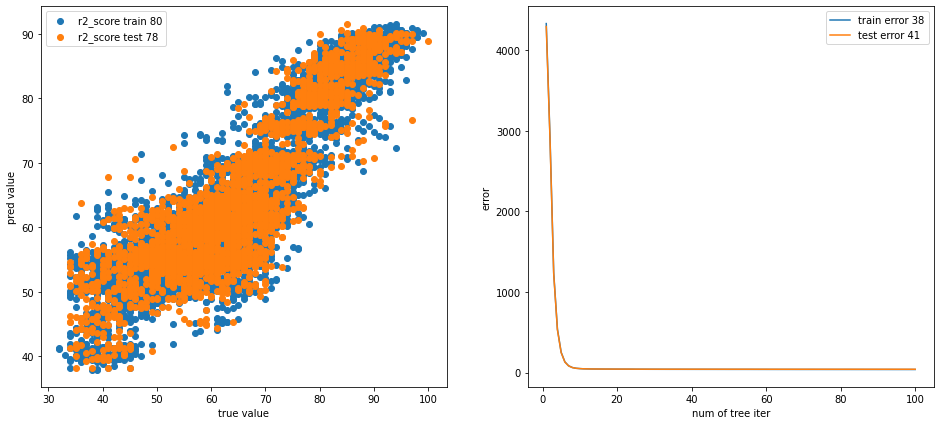

In [39]:
X_data = train_ds.drop(['mean_exam_points', 'Id'], axis=1)

 #<AxesSubplot:title={'center':'age'}>,
 #       <AxesSubplot:title={'center':'years_of_experience'}>],
 #      [<AxesSubplot:title={'center':'lesson_price'}>,
 #       <AxesSubplot:title={'center':'qualification'}>,

#Features = ['age', 'years_of_experience', 'lesson_price', 'qualification']
#X_data = train_ds[Features]
y_data = train_ds['mean_exam_points']

X_train, X_test, y_train, y_test = train_test_split(X_data.values, y_data.values, 0.7, 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)



gb_model = GB_trees(X_train, y_train, X_test=X_test, y_test=y_test, n_trees=100, max_depth=6, eta=0.18, is_rand_gb=False, model_type='DT_regressor', min_leaf=5,
                   is_bootstrap=False, featureSelection=False)

pred_train = gb_model.predict(X_train)
pred_test = gb_model.predict(X_test)

print(r2_score(y_test, pred_test))

plot_results(y_train, y_test, pred_train, pred_test, gb_model.train_errors, gb_model.test_errors)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.68s/it]


0.7742452403351854


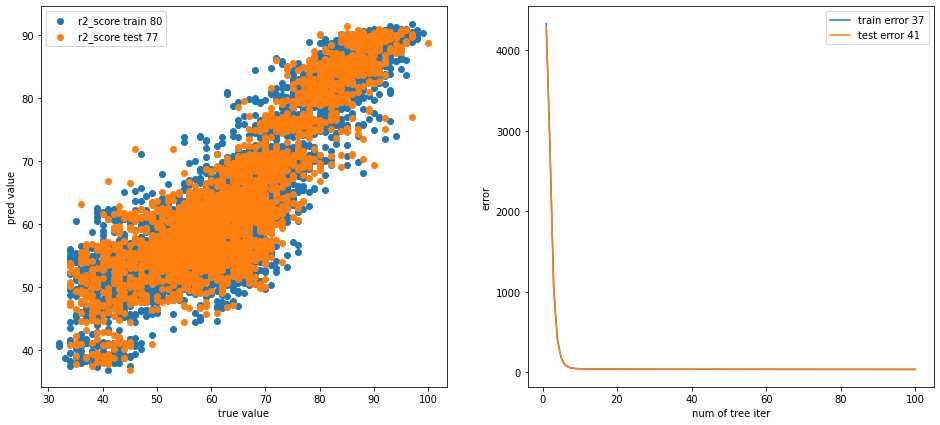

In [30]:

gb_model = GB_trees(X_train, y_train, X_test=X_test, y_test=y_test, n_trees=100, max_depth=7, eta=0.2, is_rand_gb=False, model_type='DT_regressor', min_leaf=5,
                   is_bootstrap=False, featureSelection=False)

pred_train = gb_model.predict(X_train)
pred_test = gb_model.predict(X_test)

print(r2_score(y_test, pred_test))

plot_results(y_train, y_test, pred_train, pred_test, gb_model.train_errors, gb_model.test_errors)

In [40]:
test_data = test_ds.drop('Id', axis=1)
test_data.shape

pred_test_data = gb_model.predict(test_data.values)

submission = pd.read_csv('submission_example.csv')
submission['mean_exam_points'] = pred_test_data
print(submission)

submission.to_csv('submission_100_6_018_load.csv', index=False)

         Id  mean_exam_points
0     10000         54.035971
1     10001         63.088386
2     10002         49.410994
3     10003         90.169757
4     10004         89.213646
...     ...               ...
9995  19995         41.715252
9996  19996         80.371778
9997  19997         55.133923
9998  19998         64.702441
9999  19999         70.802212

[10000 rows x 2 columns]
